## This notebook explore the usage of spacy library, pandas, WordCould visualization, and fasttext for test classification.

In [1]:
import pandas as pd, numpy as np
import fasttext
import spacy
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from  nltk.stem.porter import PorterStemmer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
print(sys.path)
    
nlp = spacy.load("en_core_web_sm")
from data_preprocess.preprocess import *
from utils.visualization import *


['/Users/marcochan/Desktop/NLP/notebooks', '/Users/marcochan/anaconda3/envs/NLP/lib/python38.zip', '/Users/marcochan/anaconda3/envs/NLP/lib/python3.8', '/Users/marcochan/anaconda3/envs/NLP/lib/python3.8/lib-dynload', '', '/Users/marcochan/anaconda3/envs/NLP/lib/python3.8/site-packages', '/Users/marcochan/anaconda3/envs/NLP/lib/python3.8/site-packages/fasttext-0.9.2-py3.8-macosx-10.9-x86_64.egg', '/Users/marcochan/anaconda3/envs/NLP/lib/python3.8/site-packages/IPython/extensions', '/Users/marcochan/.ipython', '/Users/marcochan/Desktop/NLP']


In [2]:
toxic_data = pd.read_csv('../dataset/toxic_comment.csv')
toxic_data.head()
# only process the first 200 rows
toxic_data = toxic_data.head(n = 200)


In [5]:
newcolumn = toxic_data['comment_text'].apply(lambda x: ' '.join(preprocess_text(x)))
toxic_data['newcolumn'] = newcolumn
toxic_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,newcolumn
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit usernam hardcor metallica fan reve...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingli stuck th...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war just guy constantl...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page


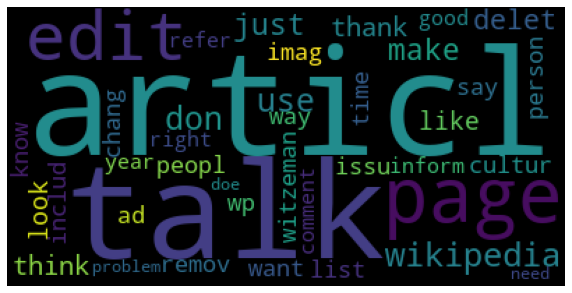

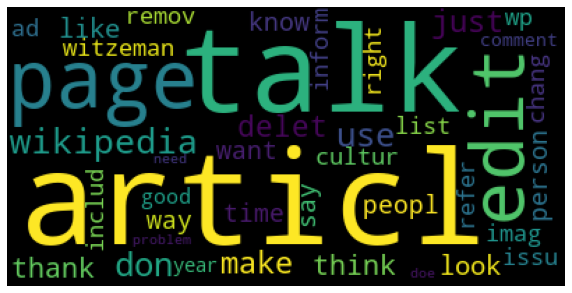

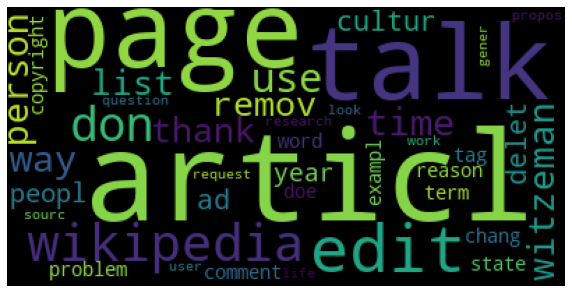

In [6]:
all_text = " ".join(toxic_data['comment_text'])
word_list = preprocess_text(all_text)
make_wc(word_list)

all_text = " ".join(toxic_data['newcolumn'])
word_list = preprocess_text(all_text)
make_wc(word_list)

# print(all_text)

doc = nlp(all_text)
word_list_noun = [token.text for token in doc if token.pos_ in ['NOUN']]
make_wc(word_list_noun)

In [7]:
def get_sentiment_score(text):
    sentiment_analyzer = SentimentIntensityAnalyzer()
    return sentiment_analyzer.polarity_scores(text)['compound']

toxic_comments = toxic_data.loc[toxic_data.toxic == 1]
# print(toxic_comments)
row_select = toxic_comments.iloc[0]
# print(row_select)
# print(toxic_comments.iloc[0, 0:2])
print('toxic comment score: ', get_sentiment_score(list(row_select['comment_text'])))


toxic_comments = toxic_data.loc[toxic_data.toxic == 0]
row_select = toxic_comments.iloc[0]
print('toxic comment score: ', get_sentiment_score(list(row_select['comment_text'])))




toxic comment score:  -0.7783
toxic comment score:  0.5574


#Classification using fasttext library

In [14]:
# ignore severe_toxic, obscene, threat, insult, identity_hate
toxic_non_toxic_data = toxic_data.loc[((toxic_data.severe_toxic==0) & (toxic_data.obscene==0) 
                                    & (toxic_data.threat == 0) & (toxic_data.insult == 0) 
                                       & (toxic_data.identity_hate == 0))]
y = toxic_non_toxic_data[['toxic']]

x_train, x_test, y_train, y_test = train_test_split(toxic_non_toxic_data, y, test_size=0.2)
# train_test_split accept dataframe as input. 
print(len(x_train))
#preparing data to train
import csv
x_train['toxic'] = ['__label__'+str(s) for s in x_train['toxic']]
data = x_train[['comment_text', 'toxic']]
data.to_csv('comments.txt', index=False, sep=' ', header=False,quoting=csv.QUOTE_NONE, quotechar="", escapechar=" ")

148


<ipython-input-14-7034e0468aef>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train['toxic'] = ['__label__'+str(s) for s in x_train['toxic']]


In [15]:
model = fasttext.train_supervised(input='comments.txt', epoch=1)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


#extracting prediction out of the fasttext output
def get_prediction(fast_out):
    return int(fast_out[0][0].split('__label__')[1])
##Training accuracy
preds = [get_prediction(model.predict(' '.join(preprocess_text(x))))  for x in list(X_train['comment_text'])]
print('accuracy:',accuracy_score(preds,y_train),'\n')

preds = [get_prediction(model.predict(' '.join(preprocess_text(x))))  for x in list(X_test['comment_text'])]
print('accuracy:',accuracy_score(preds,y_test),'\n')

##Training F1-score
print('F1-score:',f1_score(preds,y_test),'\n')